In [1]:
import pyedflib
import networkx as nx
import connectivipy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import community
from collections import defaultdict, Counter
from scipy import signal

import warnings
warnings.filterwarnings('ignore')

# Table of Contents
[1. Connectivity graph](#1)

[2. Graph theory indices](#2)
     
[3. Motif analysis](#3)
   
[4. Community detection](#4)

# Import files

In [2]:
# eyes open ------------------------------------------------------------
filename = "../input/S064R01.edf"

f = pyedflib.EdfReader(filename)

n = f.signals_in_file
labels = f.getSignalLabels()
sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)
signal_open = sigbufs
freq_open = f.getSampleFrequency(0)
f._close()

# eyes closed ------------------------------------------------------------
filename = "../input/S064R02.edf"

f = pyedflib.EdfReader(filename)

sigbufs = np.zeros((n, f.getNSamples()[0]))

for i in np.arange(n):
    sigbufs[i, :] = f.readSignal(i)
signal_closed = sigbufs
freq_closed = f.getSampleFrequency(0)
f._close()

# ------------------------------------------------------------------------
print("number of signals: \n\t", n)
print("name of all signals: \n\t", labels)
print("time: \n\t", f.getNSamples()[0])

# dictinary to map idx and name of signals. (This will be used coming question Q1.4)
label_dict = {idx: signal for idx, signal in enumerate(labels)}

del f
signal_open.shape, signal_closed.shape

number of signals: 
	 64
name of all signals: 
	 ['Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..', 'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..', 'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.', 'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']
time: 
	 9760


((64, 9760), (64, 9760))

# 1. Connectivity graph  <a name="1"></a>

## 1.1 (mandatory) ------------------------------------------------------------
### Estimate functional brain connectivity among 64 channels using one of the MVAR estimators: Partial Directed Coherence (PDC), Direct Transfer Function (DTF)
### Apply a threshold so that the resulting binary connectivity matrices have network density equal to 20%. Create a graphical representation of the binary adjacency matrix.

### Steps to create connectivity matrix
> ##### 1. Build MVAR model
##### 2. Find an optimal order $p$ which minimize the error (white Gaussian noise) $E$
##### 3. Fit the MVAR model using the obtained optimal order $p$
##### 4. Obtain coefficients(model parameters) of AR models ($p$, N, N) & prediction error (residual matrix)(N, N) 
##### 5. Apply these parameters to Estimator we choose (PDC or DTF)
##### 6. Pick the matrix with the best frequency

#### Considering step #6, we have to find the best frequency. Here is the method to find the best frequency

In [3]:
def ChannelSelection(inputSignal, inputfreq, inputLobes, nps=160):
    """ The power spectral density is calculated using 
        the reference from scipy documention for signal.welch """
    
    bestchannel, optimumAlphafreq, max_psd = 0, 0, 0
    for i in inputLobes:       
        f, Pxx_den = signal.welch(x=inputSignal[i, :], fs=inputfreq, nperseg=nps)
        
        # frequency range for alpha waves when subject eyes are closed
        alphaWaveRange = np.where((f >= 8) & (f <= 13))
        
        plt.title('Alpha waves with their PSD in Occipetal Lobe')
        plt.plot(alphaWaveRange[0],Pxx_den[alphaWaveRange])
        
        # The index of the alpha wave with more power spectral density
        bestAlpha_index = np.argmax(Pxx_den[alphaWaveRange])
    
        if max(max_psd, Pxx_den[bestAlpha_index]) > max_psd:
            max_psd = Pxx_den[bestAlpha_index]
            bestchannel = i
            #The index of best frequency for alpha waves in the 8 >= frequency range <= 13
            optimumAlphafreq = f[bestAlpha_index]+8
         
    plt.show()
    
    return bestchannel, optimumAlphafreq

Occipital indexes: 55 56 57 58 59 60 61 62


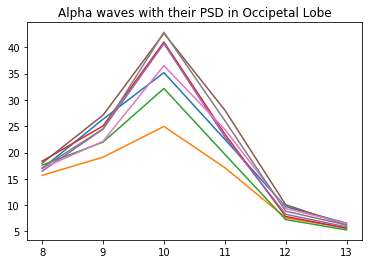

The channel that is interesting is Po3. with the frequency 10 hertz


In [4]:
# Get only occipital lobes
O_Lobes = list(idx for idx, name in enumerate(labels) if 'o' in name.lower())
print("Occipital indexes:", " ".join(map(str, O_Lobes)))
bestchannel, maxAlphafreq = ChannelSelection(inputSignal=signal_closed, inputfreq=160, inputLobes=O_Lobes)
print('The channel that is interesting is {} with the frequency {} hertz'.format(label_dict[bestchannel],int(maxAlphafreq)))

In [5]:
def create_connectivity_matrix(signals, labels,  freq,  estimator = "PDC", akaike_plot = False, significance = False):
    # 1. Build MVAR model --------------------------------------------------------------------------------------------
    mv = cp.Mvar
    
    # 2. Find an optimal order  p -------------------------------------------------------------------------------------
    # Akaike criterion of MVAR order estimation.
    best_order, crit = mv.order_akaike(data=signals, p_max=20, method='yw') # vm, ns also work
    # crit: order criterion values for each value of order p starting from 1
    print("best order by AIC:", best_order)
    
    if akaike_plot:
        plt.plot(1+np.arange(len(crit)), crit, 'g')
        plt.show()
    
    # 3. Fit the MVAR model using the obtained optimal order  p -----------------------------------------------
    # Transforming matrix to connectivipy 
    data = cp.Data(data = signals,  fs = freq,  chan_names = labels )# fs: sampling frequency
    # Fit the model using obtained best order
    data.fit_mvar(p = best_order,  method =  'yw') # p: estimation order
    
    # 4. Obtain coefficients and residual errors ---------------------------------------------------------------------
    # acoef: fitted parameters, vcoef: residual matrix
    # acoef shape (p, N, N), vcoef shape (N, N)
    acoef, vcoef = data.mvar_coefficients
    
    # 5. Apply these parameters to Estimator -----------------------------------------------------------------------
    if estimator == "PDC":
        pdc = cp.conn.PDC()
        val = pdc.calculate(acoef, vcoef, freq) # resolution: number of spectrum data points
    if estimator == "DTF":
        dtf = cp.conn.DTF()
        val = dtf.calculate(acoef, vcoef, freq)
        
    # 6. Pick the matrix with the best frequency ---------------------------------------------------------------------
    best_frequency = maxAlphafreq
    matrix = val[int(best_frequency), :, :].reshape((len(labels), len(labels)))
    np.fill_diagonal(matrix, 0)
    
    return matrix

### We choose DTF estimator 

In [6]:
matrix_open_dtf = create_connectivity_matrix(signal_open, labels, freq_open, estimator="DTF")
matrix_closed_dtf = create_connectivity_matrix(signal_closed, labels, freq_open, estimator="DTF")

best order by AIC: 5
best order by AIC: 5


#### Apply a threshold so that the resulting binary connectivity matrices have network density equal to 20%

In [7]:
# eyes open --------------------------------------------------------------------
# all values in matrix
thresholds = [item for sublist in matrix_open_dtf for item in sublist]
for threshold in thresholds:
    binary_open = (matrix_open_dtf > threshold).astype(int)
    G = nx.from_numpy_matrix(binary_open, create_using=nx.MultiDiGraph())
    density = nx.density(G)*100
    if density*0.99 < 20 and 20 < density*1.01: # Because it cannot be exact target density
        break
print("eyes open \t threshold:", round(threshold, 3), "\t density: ", round(density,0), "%")

# eyes closed --------------------------------------------------------------------
# all values in matrix
thresholds = [item for sublist in matrix_closed_dtf for item in sublist]
for threshold in thresholds:
    binary_closed = (matrix_closed_dtf > threshold).astype(int)
    G = nx.from_numpy_matrix(binary_closed, create_using=nx.MultiDiGraph())
    density = nx.density(G)*100
    if density*0.99 < 20 and 20 < density*1.01: # Because it cannot be exact target density
        break
print("eyes closed \t threshold:", round(threshold, 3), "\t density: ", round(density,0), "%")

eyes open 	 threshold: 0.128 	 density:  20.0 %
eyes closed 	 threshold: 0.13 	 density:  20.0 %


#### Finally, we create a graphical representation of the binary adjacency matrix.

In [8]:
"""
this function is to print and plot of connectivity matrix for both PDC and DTF
"""
def plot_binary_matrix(matrix_open, matrix_closed, density, estimator, file_name = None, save_file = False):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    mat_open = axes[0].imshow(matrix_open, cmap="viridis")
    axes[0].set_title(str(estimator) + " EO " + str(density) +"% density")
    mat_closed = axes[1].imshow(matrix_closed, cmap="viridis")
    axes[1].set_title(str(estimator) + " EC "+ str(density) + "% density")
    if save_file:
        plt.savefig(file_name + ".png")
    plt.show()

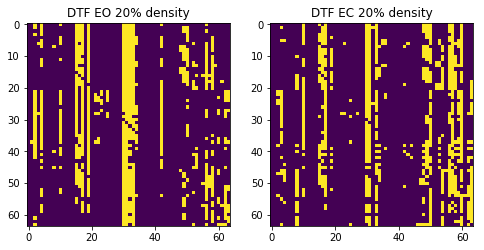

In [9]:
plot_binary_matrix(binary_open, binary_closed, 20, "DTF")

## 1.2 (A) ---------------------------------------------------------------------------
## Both estimators (PDC & DTF)

### PDC

In [10]:
matrix_open_pdc = create_connectivity_matrix(signal_open, labels, freq_open, estimator="PDC")
matrix_closed_pdc = create_connectivity_matrix(signal_closed, labels, freq_open, estimator="PDC")

best order by AIC: 5
best order by AIC: 5


## 1.3 (A) ---------------------------------------------------------------------------
### thresholds yielding the following density values: 1%, 5%, 10%, 20%, 30%, 50%

In [11]:
density_list = [50, 30, 20, 10, 5, 1]

## DTF

eyes open 	 threshold: 0.055 	 density:  50.0 %
eyes closed 	 threshold: 0.057 	 density:  50.0 %


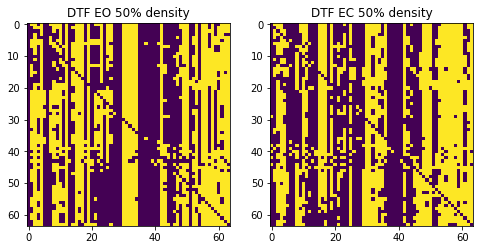

eyes open 	 threshold: 0.094 	 density:  30.0 %
eyes closed 	 threshold: 0.1 	 density:  30.0 %


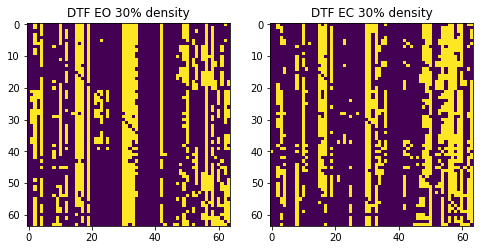

eyes open 	 threshold: 0.128 	 density:  20.0 %
eyes closed 	 threshold: 0.132 	 density:  20.0 %


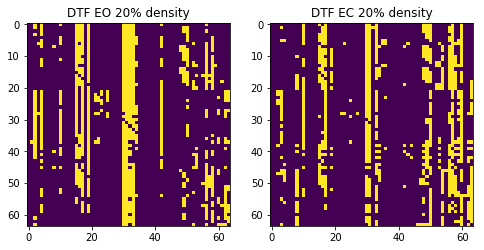

eyes open 	 threshold: 0.179 	 density:  10.0 %
eyes closed 	 threshold: 0.195 	 density:  10.0 %


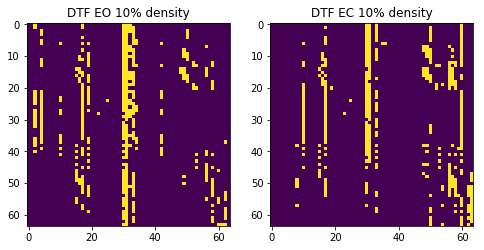

eyes open 	 threshold: 0.231 	 density:  5.0 %
eyes closed 	 threshold: 0.255 	 density:  5.0 %


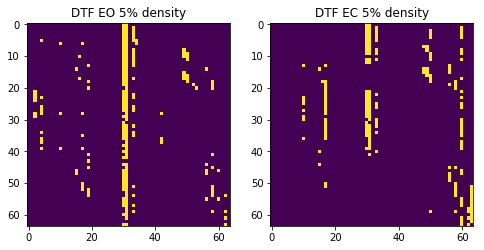

eyes open 	 threshold: 0.368 	 density:  1.0 %
eyes closed 	 threshold: 0.351 	 density:  1.0 %


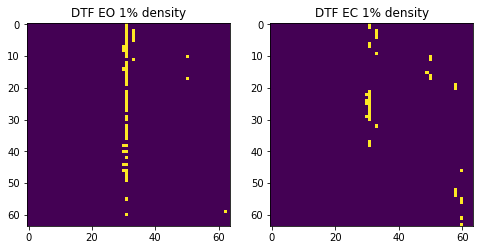

In [13]:
dtf_binary_matrix = {"EO":{}, "EC":{}} # To keep the matrix for later questions

for idx, target_density in enumerate(density_list):
    thresholds = [item for sublist in matrix_open_dtf for item in sublist]
    for threshold in thresholds:
        # create binary adjacency matrix
        binary_open = (matrix_open_dtf > threshold).astype(int)
        G = nx.from_numpy_matrix(binary_open, create_using=nx.MultiDiGraph())
        # compute density
        density = round(nx.density(G)*100, 0)
        if density ==  target_density:
            matrix_open_dtf[matrix_open_dtf < threshold] = 0
            break
    dtf_binary_matrix["EO"][target_density] = binary_open
    print("eyes open \t threshold:", round(threshold, 3), "\t density: ", density, "%")

    # eyes closed --------------------------------------------------------------------
    thresholds = [item for sublist in matrix_closed_dtf for item in sublist]
    for threshold in thresholds:
        binary_closed = (matrix_closed_dtf > threshold).astype(int)
        G = nx.from_numpy_matrix(binary_closed, create_using=nx.MultiDiGraph())
        density = round(nx.density(G)*100, 0)
        if density ==  target_density:
            matrix_closed_dtf[matrix_closed_dtf < threshold] = 0
            break 
    dtf_binary_matrix["EC"][target_density] = binary_closed
    print("eyes closed \t threshold:", round(threshold, 3), "\t density: ", density, "%")
    
    name = "../output/1.3_DTF_" + str(target_density)
    plot_binary_matrix(binary_open, binary_closed, target_density, "DTF", file_name=name, save_file=True)

## PDC

eyes open 	 threshold: 0.053 	 density:  50.0 %
eyes closed 	 threshold: 0.056 	 density:  50.0 %


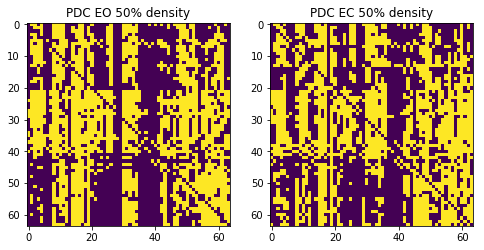

eyes open 	 threshold: 0.082 	 density:  30.0 %
eyes closed 	 threshold: 0.084 	 density:  30.0 %


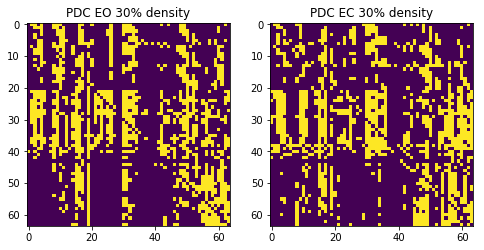

eyes open 	 threshold: 0.102 	 density:  20.0 %
eyes closed 	 threshold: 0.108 	 density:  20.0 %


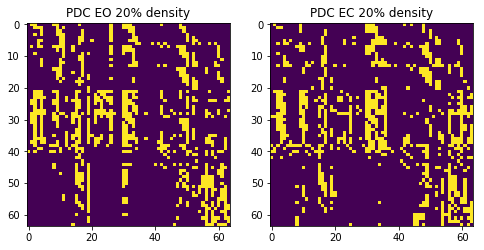

eyes open 	 threshold: 0.132 	 density:  10.0 %
eyes closed 	 threshold: 0.144 	 density:  10.0 %


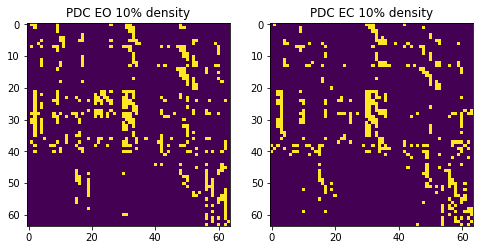

eyes open 	 threshold: 0.168 	 density:  5.0 %
eyes closed 	 threshold: 0.178 	 density:  5.0 %


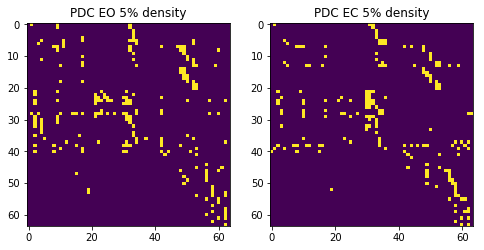

eyes open 	 threshold: 0.248 	 density:  1.0 %
eyes closed 	 threshold: 0.233 	 density:  1.0 %


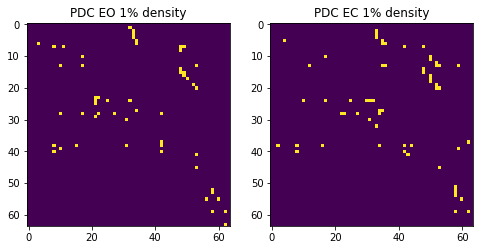

In [14]:
pdc_binary_matrix = {"EO":{}, "EC":{}} # To keep the matrix for later questions

for idx, target_density in enumerate(density_list):
    thresholds = [item for sublist in matrix_open_pdc for item in sublist]
    for threshold in thresholds:
        binary_open = (matrix_open_pdc > threshold).astype(int)
        G = nx.from_numpy_matrix(binary_open, create_using=nx.MultiDiGraph())
        density = round(nx.density(G)*100, 0)
        if density ==  target_density:
            matrix_open_pdc[matrix_open_pdc < threshold] = 0

            break
    pdc_binary_matrix["EO"][target_density] = binary_open
    print("eyes open \t threshold:", round(threshold, 3), "\t density: ", density, "%")

   # eyes closed --------------------------------------------------------------------
    thresholds = [item for sublist in matrix_closed_pdc for item in sublist]
    for threshold in thresholds:
        binary_closed = (matrix_closed_pdc > threshold).astype(int)
        G = nx.from_numpy_matrix(binary_closed, create_using=nx.MultiDiGraph())
        density = round(nx.density(G)*100, 0)
        if density ==  target_density:
            matrix_closed_pdc[matrix_closed_pdc < threshold] = 0

            break 
    pdc_binary_matrix["EC"][target_density] = binary_closed
    print("eyes closed \t threshold:", round(threshold, 3), "\t density: ", density, "%")
    
    name = "../output/1.3_PDC_" + str(target_density)
    plot_binary_matrix(binary_open, binary_closed, target_density, "PDC", file_name=name, save_file=True)

## 1.5 (C) -------------------------------------------------------------------------
### Make a topographical representation of the networks
#### the choice of this task is advised in the case of 19-channel networks and/or density≤5%

### Considering 19 channels

In [17]:
labels_19 = ["Fp1.", "Fp2.", "F7..", "F3..", "Fz..", "F4..", "F8..", "T7..", "C3..", "Cz..", 
                  "C4..", "T8..", "P7..", "P3..", "Pz..", "P4..", "P8..", "O1..", "O2.."]

# Create a dictinary including only 19 signals (key: index, value: name of signals)
label_19_dict = {key: signal for key, signal in label_dict.items() if signal in labels_19}

signals_idx_19 = list(label_19_dict.keys()) # Return the index of rows that we extract original signal logs
signal_open_19 =signal_open[signals_idx_19, :]
signal_closed_19 =signal_closed[signals_idx_19, :]
labels_19 = label_19_dict.values()

print(signal_open_19.shape, signal_closed_19.shape)

# Another dictionary (key: [0, 18] by order, value: name of signals) 
# This is used in order to find the signals which will be filtered out by signanificnace values
label_19_dict = {idx: name for idx, name in enumerate(label_19_dict.values())}

locations= pd.read_csv("../input/channel_locations.txt", sep=" ")[["label", "x", "y"]]
x=locations.x.values
y=locations.y.values
positions = {idx: [x[idx], y[idx]] for idx in range(len(locations))}

# regarding 19 signals ----------------------------------------------------------
locations_19 = locations.loc[locations['label'].isin(labels_19)]
x_19 = locations_19.x.values
y_19 = locations_19.y.values
positions_19 = {idx: [x_19[idx], y_19[idx]] for idx in range(len(locations_19))}

(19, 9760) (19, 9760)


#### Create matrices for both estimators and eyes open and closed

In [18]:
matrix_open_pdc_19 = create_connectivity_matrix(signal_open_19, labels_19, freq_open, estimator="PDC")
matrix_closed_pdc_19 = create_connectivity_matrix(signal_closed_19, labels_19, freq_closed, estimator="PDC")
matrix_open_dtf_19 = create_connectivity_matrix(signal_open_19, labels_19, freq_open, estimator="DTF")
matrix_closed_dtf_19 = create_connectivity_matrix(signal_closed_19, labels_19, freq_closed, estimator="DTF")
list_of_matrix = [matrix_open_pdc_19, matrix_closed_pdc_19, matrix_open_dtf_19, matrix_closed_dtf_19]
print(matrix_open_pdc_19.shape, matrix_closed_pdc_19.shape, matrix_open_dtf_19.shape, matrix_closed_dtf_19.shape )

best order by AIC: 8
best order by AIC: 13
best order by AIC: 8
best order by AIC: 13
(19, 19) (19, 19) (19, 19) (19, 19)


##### Set threshold satisfying that the density equals to 5%

In [19]:
for idx, matrix in enumerate(list_of_matrix):
    thresholds = [item for sublist in matrix for item in sublist]

    for threshold in thresholds:
        binary_matrix = (matrix > threshold).astype(int)
        G = nx.from_numpy_matrix(binary_matrix, create_using=nx.MultiDiGraph())
        density = round(nx.density(G)*100, 0)
        if density == 5:        
            rows = np.nonzero(binary_matrix == 0)[0] # index of row which is not connected
            cols = np.nonzero(binary_matrix == 0)[1]  # index of column which is not connected
            # delete values in original matrix in order to make density 5%
            for index in range(len(rows)):
                    matrix[rows[index]][cols[index]] = 0
            break
    list_of_matrix[idx] = matrix

##### Create toporographical representation for each cases

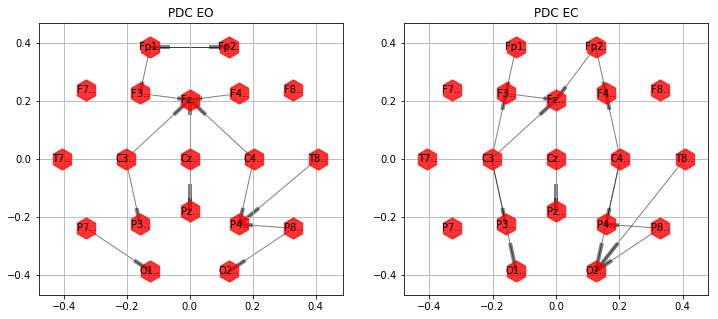

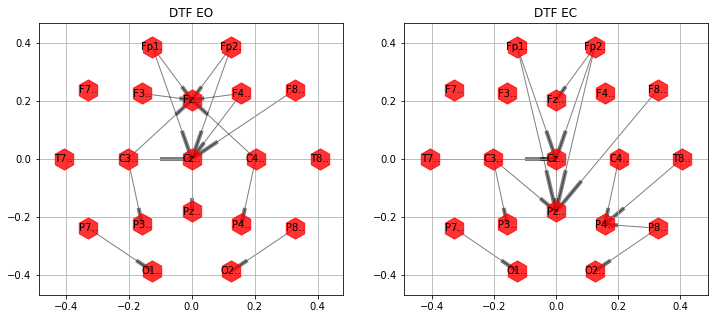

In [21]:
estimators = ["PDC", "DTF"]
eyes = ["EO", "EC"]

for i in range(len(estimators)):
    
    fig, ax = plt.subplots(1, 2, figsize=((12, 5)))

    for idx, matrix in enumerate(list_of_matrix[i*2:(i+1)*2]):

        G = nx.from_numpy_matrix(matrix, create_using=nx.MultiDiGraph())
        for n, coordinate in positions_19.items():
            G.node[n]['pos'] = coordinate

        nx.draw_networkx_nodes(G, positions_19, node_color='r', node_shape="h", alpha=0.8, node_size=450, ax = ax[idx])
        nx.draw_networkx_edges(G, positions_19, width=1.0, alpha=0.5, ax = ax[idx])
        nx.draw_networkx_labels(G, positions_19, label_19_dict, font_size=10, ax = ax[idx])
        name = estimators[i] + " " + eyes[idx]
        ax[idx].set_title(name)
        ax[idx].grid()
            
    plt.savefig("../output/1.5_" + estimators[i] + ".png")
    plt.show()

# 2. Graph theory indices <a name="2"></a>

## 2.1 (mandatory), 2.3 (B), 2.4 (C) ----------------------------------------------
### Do all these questions at once
*  ## 2.1  
 ##### Compute binary global (clustering coefficient, path length) and local (degree, in/out-degree) graph indices. List the highest 10 channels for local indices.
*  ## 2.3
 ##### Compare the global indices extracted from PDC and DTF connectivity estimations
*  ## 2.4
 ##### Study the behaviour of global graph indices in function of network density (see point 2.3 for density values). (the choice of this task is advised in the case of selection of task 1.3).

In [22]:
df = pd.DataFrame(columns=["Estimator", "Eyes", "Density", "Clustering_Coefficient", "Path_Length",
                                                 "High_Degree", "High_In-Degree", "High_Out-Degree"])
estimator = ["PDC", "DTF"]

for i, matrix in enumerate([pdc_binary_matrix, dtf_binary_matrix]):
    for eyes in ["EO", "EC"]:
        for density in density_list:
            info_indices = [estimator[i], eyes, density]
            curr_matrix = matrix[eyes][density]
            
            # Global graph indices  ----------------------------------------------------------------------------------------------------
            # Global Clustering Coefficient
            G = nx.from_numpy_matrix(curr_matrix)
            gcc = round(nx.average_clustering(G), 3)
            info_indices.append(gcc)
            
            # Average Path Length
            G = nx.from_numpy_matrix(curr_matrix, create_using=nx.MultiDiGraph())
            G.remove_nodes_from(list(nx.isolates(G)))
            try:
                apl = round(nx.average_shortest_path_length(G),3)
            except:
                apl = "not fully connected"
            info_indices.append(apl)
            
             # Local graph indices  -----------------------------------------------------------------------------------------------------
            degrees = G.degree()
            degrees = sorted([(k, degrees[k]) for k in degrees], key=lambda x:x[1], reverse=True)
            top10 = [label_dict[signal[0]] for signal in degrees[:10]]
            info_indices.append(top10)

            degrees = G.in_degree()
            degrees=sorted([(k, degrees[k]) for k in degrees], key=lambda x:x[1], reverse=True)
            top10 = [label_dict[signal[0]] for signal in degrees[:10] ]
            info_indices.append(top10)

            degrees = G.out_degree()
            degrees=sorted([(k, degrees[k]) for k in degrees], key=lambda x:x[1], reverse=True)
            top10 = [label_dict[signal[0]] for signal in degrees[:10] ]
            info_indices.append(top10)
            
            df.loc[len(df)] = info_indices

df_global = df[["Estimator", "Eyes", "Density", "Clustering_Coefficient", "Path_Length"]]
df_local = df[["Estimator", "Eyes", "Density", "High_Degree", "High_In-Degree", "High_Out-Degree"]]

## 2.3
#### Compare the global indices extracted from PDC and DTF connectivity estimations

In [24]:
df_global.to_csv("../output/2.3_df_global.csv", sep = "\t", index=False, header=True)
df_global

Estimator Eyes Density  Clustering_Coefficient          Path_Length
0        PDC   EO      50                   0.803                1.581
1        PDC   EO      30                   0.602                1.812
2        PDC   EO      20                   0.497                1.911
3        PDC   EO      10                   0.381                1.077
4        PDC   EO       5                   0.274                0.372
5        PDC   EO       1                   0.048  not fully connected
6        PDC   EC      50                   0.799                1.557
7        PDC   EC      30                   0.620                2.001
8        PDC   EC      20                   0.506                 2.23
9        PDC   EC      10                   0.400                1.402
10       PDC   EC       5                   0.314                 0.32
11       PDC   EC       1                   0.087  not fully connected
12       DTF   EO      50                   0.859                1.232
13       DTF   EO      30                   0.783                1.079
14       DTF   EO      20                   0.734                0.676
15       DTF   EO      10                   0.683                0.593
16       DTF   EO       5                   0.707                0.123
17       DTF   EO       1                   0.180  not fully connected
18       DTF   EC      50                   0.850                1.376
19       DTF   EC      30                   0.738                1.086
20       DTF   EC      20                   0.722                0.936
21       DTF   EC      10                   0.635                0.603
22       DTF   EC       5                   0.555                0.237
23       DTF   EC       1                   0.069  not fully connected

In [27]:
df_global_pdc_eo = df_global[0:6]
df_global_pdc_ec = df_global[6:12]
df_global_dtf_eo = df_global[12:18]
df_global_dtf_ec = df_global[18:24]

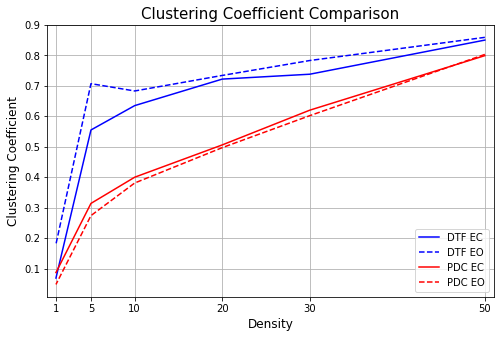

In [60]:
plt.figure(figsize = (8, 5))
ax = plt.gca()

df_global_dtf_ec.plot(kind='line', x='Density', y='Clustering_Coefficient', ax=ax, label = "DTF EC", color = "blue")
df_global_dtf_eo.plot(kind='line', x='Density', y='Clustering_Coefficient', ax=ax, label = "DTF EO", style = "--", color = "blue")
df_global_pdc_ec.plot(kind='line', x='Density', y='Clustering_Coefficient', ax=ax, label = "PDC EC", color = "red")
df_global_pdc_eo.plot(kind='line', x='Density', y='Clustering_Coefficient', ax=ax, label = "PDC EO", style = "--", color = "red")

plt.ylabel("Clustering Coefficient", fontsize=12)
plt.xlabel("Density", fontsize=12)
plt.title("Clustering Coefficient Comparison", fontsize=15)
plt.xticks([1, 5, 10, 20, 30, 50])
plt.xlim((0, 51))
plt.grid()
plt.savefig("../output/2.3_CC.png")
plt.show()

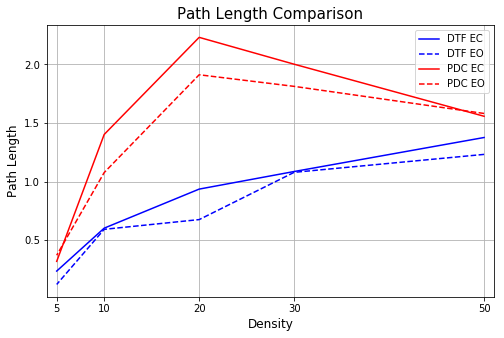

In [59]:
plt.figure(figsize = (8, 5))
ax = plt.gca()

df_global_dtf_ec[:5].plot(kind='line', x='Density', y='Path_Length', ax=ax, label = "DTF EC", color = "blue")
df_global_dtf_eo[:5].plot(kind='line', x='Density', y='Path_Length', ax=ax, label = "DTF EO", style = "--", color = "blue")
df_global_pdc_ec[:5].plot(kind='line', x='Density', y='Path_Length', ax=ax, label = "PDC EC", color = "red")
df_global_pdc_eo[:5].plot(kind='line', x='Density', y='Path_Length', ax=ax, label = "PDC EO", style = "--", color = "red")

plt.ylabel("Path Length", fontsize=12)
plt.xlabel("Density", fontsize=12)
plt.title("Path Length Comparison", fontsize=15)
plt.xticks([5, 10, 20, 30, 50])
plt.xlim((4, 51))
plt.grid()
plt.savefig("../output/2.3_PL.png")
plt.show()

## 2.5 (B) ------------------------------------------------------------
#### Make a topographical representation of local indices.

In [30]:
df_local

Estimator Eyes Density                                        High_Degree  \
0        PDC   EO      50  [F5.., F1.., F3.., Pz.., C3.., F2.., Cpz., Po3...   
1        PDC   EO      30  [F5.., F3.., Cp4., Pz.., Cp3., Cp1., Afz., P1....   
2        PDC   EO      20  [F5.., Pz.., F3.., Cp4., Cp1., Afz., Po3., Cp3...   
3        PDC   EO      10  [F3.., Fz.., F5.., Pz.., Af8., F1.., Fc1., Fp2...   
4        PDC   EO       5  [Af8., Af7., F3.., F1.., Fc1., C1.., Cpz., Fp2...   
5        PDC   EO       1  [Af8., P6.., C5.., C3.., Cz.., Cpz., Fp1., Ft7...   
6        PDC   EC      50  [P1.., Cp4., Cpz., F5.., Po3., Cp3., Fz.., O1....   
7        PDC   EC      30  [Po3., Cpz., F5.., Fz.., F3.., F6.., P1.., O1....   
8        PDC   EC      20  [F6.., Po3., Fz.., Cpz., F3.., O1.., F1.., P1....   
9        PDC   EC      10  [F3.., F5.., Fz.., Pz.., F6.., Af8., C6.., F1....   
10       PDC   EC       5  [Ft7., C6.., Fz.., F5.., F3.., F1.., P1.., Pz....   
11       PDC   EC       1  [C6.., Af7., Ft7., Pz.., P4.., Po4., Af8., Fz....   
12       DTF   EO      50  [Iz.., Cp4., Po7., F5.., C4.., F3.., Fc2., Po3...   
13       DTF   EO      30  [Cp4., F5.., F3.., Po3., Cp3., Cpz., F1.., Cp1...   
14       DTF   EO      20  [F5.., F3.., Cp4., F1.., Fz.., Cpz., Cp3., Po3...   
15       DTF   EO      10  [F3.., F5.., Fz.., Cpz., Cp4., Fc2., F1.., Fc1...   
16       DTF   EO       5  [F3.., F5.., Fz.., Cpz., Cp4., Fc2., Po4., Fc1...   
17       DTF   EO       1  [F3.., F5.., Fz.., Fc1., Fcz., Fc2., Fc4., C5....   
18       DTF   EC      50  [P8.., Cp3., P3.., Pz.., Poz., P1.., Po3., Fz....   
19       DTF   EC      30  [F5.., F3.., Pz.., Po3., Poz., Cpz., P8.., O1....   
20       DTF   EC      20  [F5.., F3.., Cpz., Poz., Pz.., O1.., Fz.., Cz....   
21       DTF   EC      10  [F5.., F3.., O1.., Cpz., Fz.., Cz.., Pz.., Po3...   
22       DTF   EC       5  [F3.., F5.., O1.., Cpz., Fz.., Iz.., Pz.., Po4...   
23       DTF   EC       1  [F3.., F5.., Fz.., Po4., O1.., Pz.., Fpz., Af7...   

                                       High_In-Degree  \
0   [Cp1., Cp4., C3.., Cp3., F5.., Cpz., Pz.., Po3...   
1   [Cp4., Cp1., F5.., Pz.., Cp3., F3.., Po3., P1....   
2   [Cp4., Pz.., F5.., Cp1., F3.., Cp3., Po3., Fc2...   
3   [Fz.., Pz.., Fc1., F3.., Po3., F5.., F1.., P4....   
4   [Fc1., F1.., F3.., Fz.., C1.., Cpz., P1.., P4....   
5   [Fp1., T9.., P3.., P6.., C3.., Cz.., Cpz., Fz....   
6   [Cp3., P1.., Cp4., Cpz., O1.., Cp1., Po3., P3....   
7   [Cpz., Po3., P1.., Cp3., O1.., Cp4., Cp1., Cz....   
8   [Po3., Cpz., O1.., P1.., Cz.., Fz.., F3.., Cp1...   
9   [Fz.., F3.., O1.., F5.., Fcz., Pz.., Cpz., F6....   
10  [F3.., Fz.., F5.., Po4., F2.., P1.., Cz.., Pz....   
11  [Pz.., Po4., Fz.., F4.., P4.., F2.., T9.., P3....   
12  [Fc2., C4.., Cp3., Cp4., F5.., F3.., T9.., Po3...   
13  [F3.., Po3., F5.., Cp4., F1.., Cp3., Cpz., Fz....   
14  [F3.., F5.., Cp4., F1.., Fz.., Cpz., Cp3., Po3...   
15  [F3.., F5.., Fz.., Cpz., Cp4., Fc2., F1.., Fc1...   
16  [F3.., F5.., Fz.., Po4., Fc2., Cp4., Cpz., Fc1...   
17  [F3.., F5.., Fz.., Pz.., O2.., Fc5., Fc3., Fc1...   
18  [F5.., F3.., O1.., Fz.., Po3., Poz., Iz.., P3....   
19  [F5.., F3.., Po3., O1.., Poz., Pz.., Cpz., Fz....   
20  [F5.., F3.., O1.., Poz., Fz.., Cpz., Pz.., Po3...   
21  [F5.., O1.., F3.., Cpz., Fz.., Cz.., Pz.., Po3...   
22  [F3.., O1.., F5.., Cpz., Fz.., Iz.., Pz.., Po4...   
23  [F3.., Fz.., Po4., O1.., F5.., Pz.., P1.., Fc5...   

                                      High_Out-Degree  
0   [Af8., Af7., F6.., Fp2., F4.., Af4., Af3., Fp1...  
1   [Af8., Af7., F6.., F4.., Af4., F7.., F5.., F8....  
2   [Af8., Af7., F6.., Fp1., F4.., Fp2., Af4., F8....  
3   [Af8., Af7., C5.., Fp2., F6.., Ft7., T7.., F7....  
4   [Af8., Af7., C5.., Ft7., T7.., Fc4., Fp2., C6....  
5   [Af8., C5.., Ft7., C6.., Af7., Fc6., Cp3., Fp2...  
6   [Ft7., C6.., Fp2., F8.., Ft8., Afz., Af8., Af7...  
7   [Ft7., Af8., Af7., Af4., F6.., Ft8., F8.., C6....  
8   [Af8., Ft7., C6.., Af4., F6.., Fp2., F8.., Ft8...  
9   [Af8., Ft7.,

In [31]:
df_local[["Estimator", "Eyes", "Density", "High_Degree"]].to_csv("../output/2.5_local_degree.txt", sep = "\t", index=False, header=True)
df_local[["Estimator", "Eyes", "Density", "High_In-Degree"]].to_csv("../output/2.5_local_indegree.txt", sep = "\t", index=False, header=True)
df_local[["Estimator", "Eyes", "Density", "High_Out-Degree"]].to_csv("../output/2.5_local_outdegree.txt", sep = "\t", index=False, header=True)

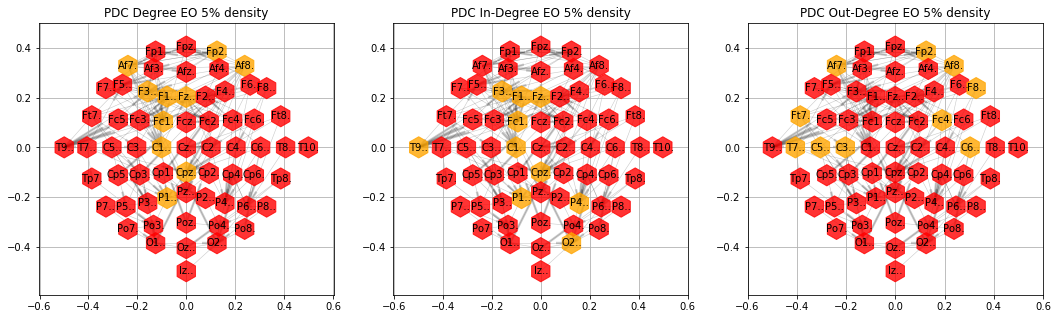

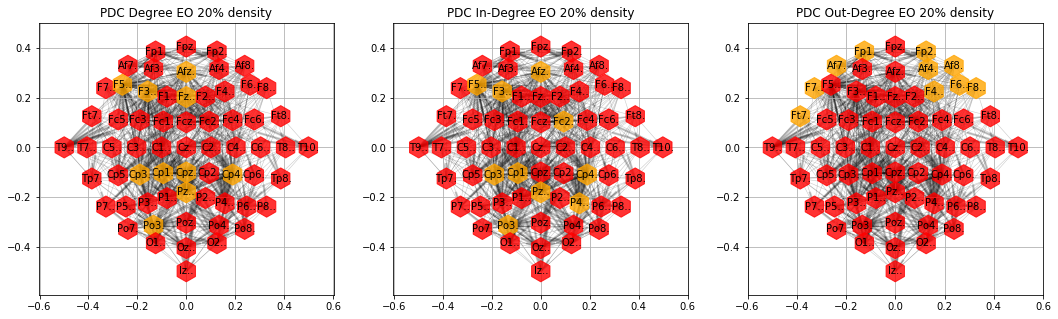

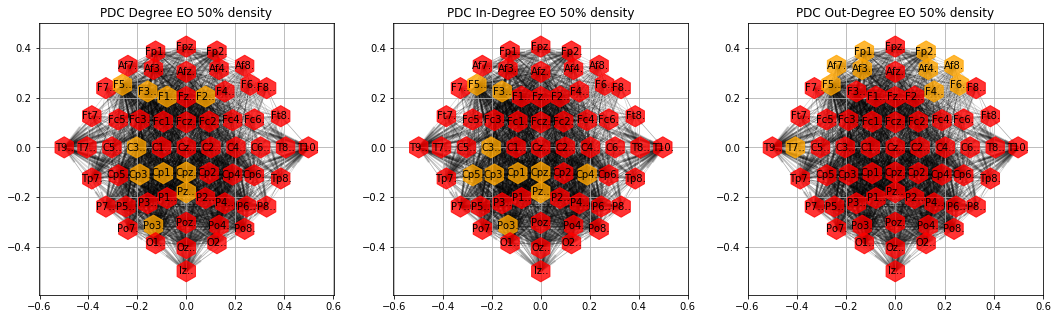

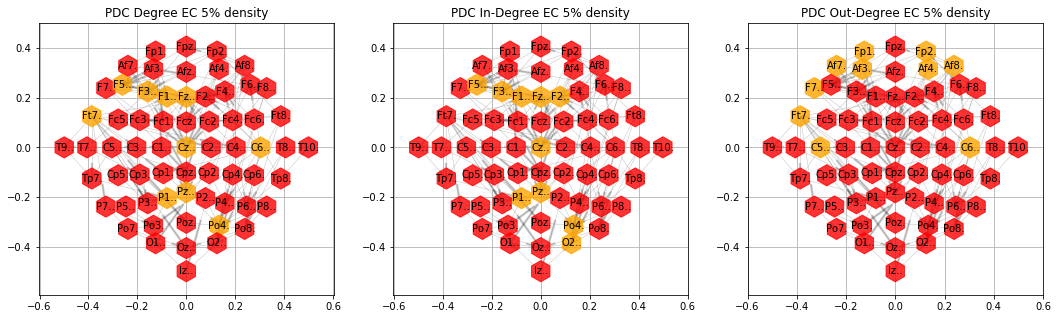

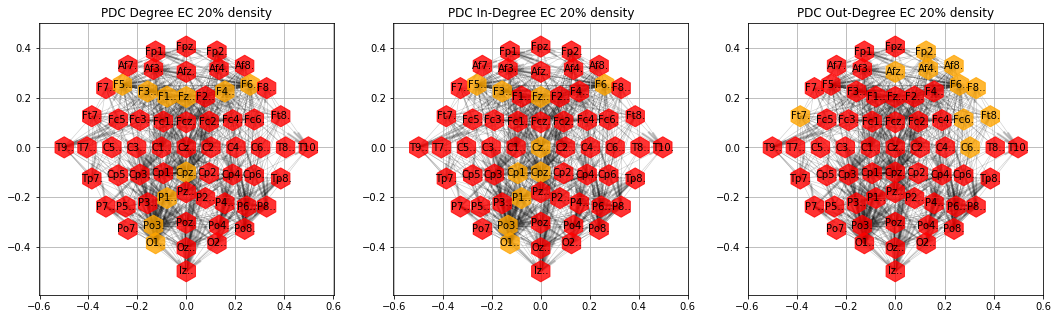

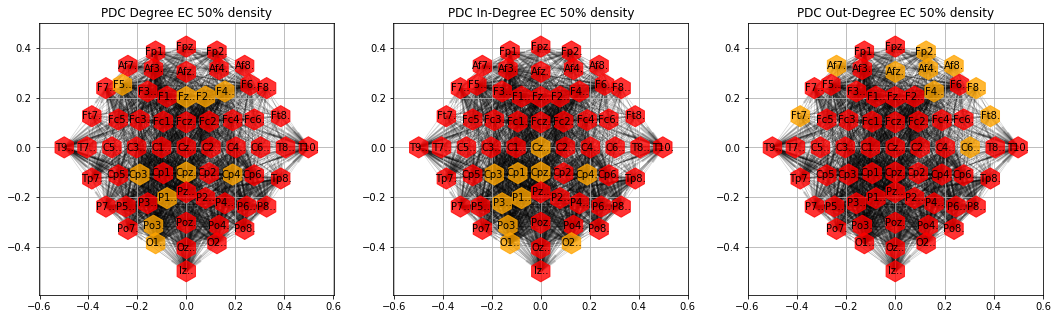

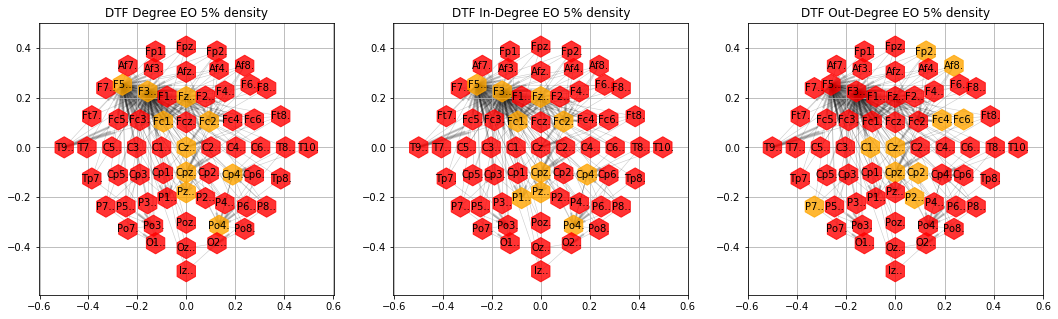

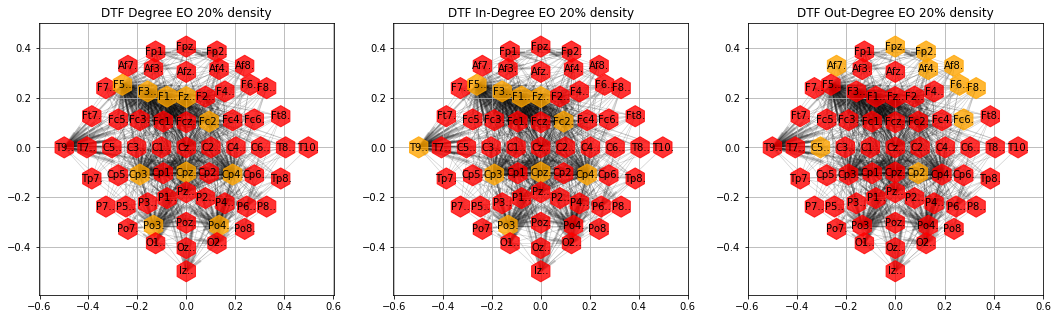

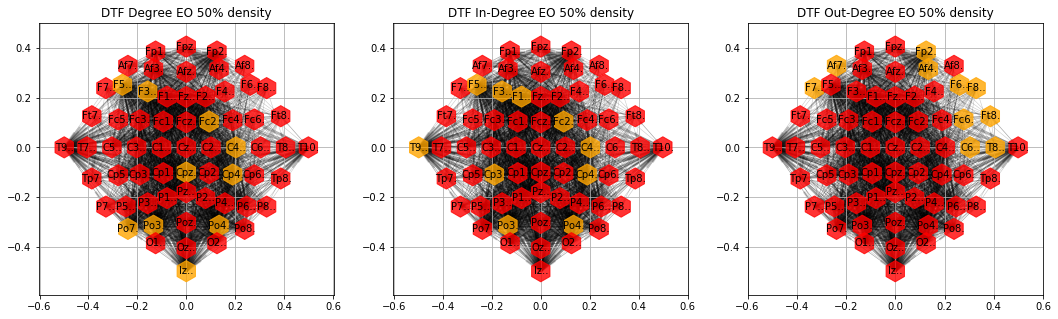

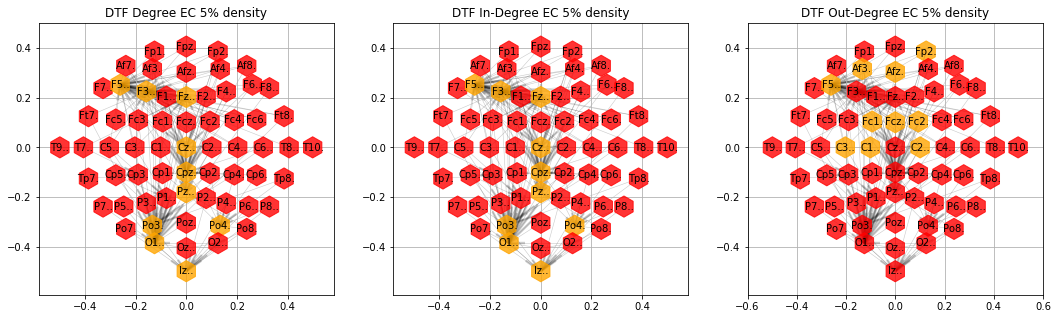

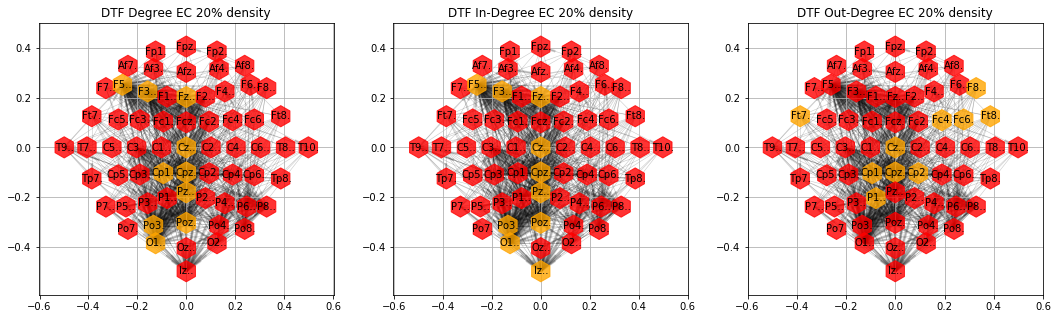

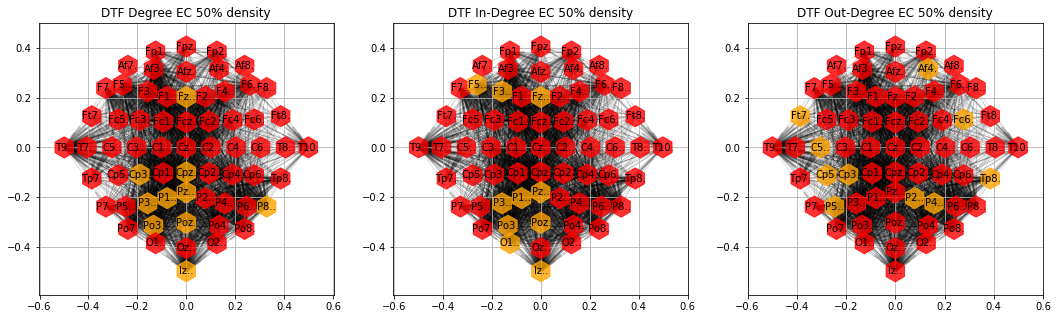

In [32]:
estimator = ["PDC", "DTF"]
colors = ["red", "orange"]

for i, matrix in enumerate([pdc_binary_matrix, dtf_binary_matrix]):
    for eyes in ["EO", "EC"]:
        for density in [5, 20, 50]:

            curr_matrix = matrix[eyes][density]
            G = nx.from_numpy_matrix(curr_matrix, create_using=nx.MultiDiGraph())
            
            fig, ax = plt.subplots(1, 3, figsize=((18, 5)))

            # Degree  -----------------------------------------------------------------------------------------------------
            degrees = G.degree()
            degrees = sorted([(k, degrees[k]) for k in degrees], key=lambda x:x[1], reverse=True)
            top10_nodes = [label[0] for label in degrees[:10]]
            
            # Plot the network
            color_map = np.zeros(len(degrees))
            for node in top10_nodes:
                color_map[node] = 1
            color_map = [colors[int(i)] for i in color_map]
            
            nx.draw_networkx_nodes(G, positions, node_color = color_map, node_shape="h", node_size=450, alpha=0.8,  ax=ax[0]) 
            nx.draw_networkx_edges(G, positions, arrowstyle="-|>", width=0.6, alpha=0.2, ax=ax[0])
            nx.draw_networkx_labels(G, positions, label_dict, font_size=10, alpha=0.1, ax=ax[0])
            name = str(estimator[i]) + " Degree " + str(eyes) + " " + str(density) + "% density"
            ax[0].set_title(name)
            ax[0].grid()
            plt.xlim((-0.6, 0.6))

            # In-Degree -----------------------------------------------------------------------------------------------------
            degrees = G.in_degree()
            degrees=sorted([(k, degrees[k]) for k in degrees], key=lambda x:x[1], reverse=True)
            top10_nodes = [label[0] for label in degrees[:10]]
            
            # Plot the network
            color_map = np.zeros(len(degrees))
            for node in top10_nodes:
                color_map[node] = 1
            color_map = [colors[int(i)] for i in color_map]
            
            nx.draw_networkx_nodes(G, positions, node_color = color_map, node_shape="h", node_size=450, alpha=0.8, ax=ax[1]) 
            nx.draw_networkx_edges(G, positions, arrowstyle="-|>", width=0.6, alpha=0.2, ax=ax[1])
            nx.draw_networkx_labels(G, positions, label_dict, font_size=10, alpha=0.1, ax=ax[1])
            name = str(estimator[i]) + " In-Degree " + str(eyes) + " " + str(density) + "% density"
            ax[1].set_title(name)
            ax[1].grid()
            plt.xlim((-0.6, 0.6))
            
            # Out-Degree -----------------------------------------------------------------------------------------------------
            degrees = G.out_degree()
            degrees=sorted([(k, degrees[k]) for k in degrees], key=lambda x:x[1], reverse=True)
            top10_nodes = [label[0] for label in degrees[:10]]
            # Plot the network
            color_map = np.zeros(len(degrees))
            for node in top10_nodes:
                color_map[node] = 1
            color_map = [colors[int(i)] for i in color_map]
            
            nx.draw_networkx_nodes(G, positions, node_color = color_map, node_shape="h", node_size=450, alpha=0.8, ax=ax[2]) 
            nx.draw_networkx_edges(G, positions, arrowstyle="-|>", width=0.6, alpha=0.2, ax=ax[2])
            nx.draw_networkx_labels(G, positions, label_dict, font_size=10, alpha=0.1, ax=ax[2])
            name = str(estimator[i]) + " Out-Degree " + str(eyes) + " " + str(density) + "% density"
            ax[2].set_title(name)
            ax[2].grid()
            plt.xlim((-0.6, 0.6))
            
            name = str(estimator[i]) + " " + str(eyes) + " " + str(density)
            plt.savefig("../output/2.5_" + name + ".png")
            plt.show()


# 3. Motif analysis <a name="3"></a>

## 3.1 (mandatory) ---------------------------------------------------------------
#### Perform motifs analysis to investigate the presence of 3-node configurations in the networks: determine their frequency and statistical significance (motifs, anti-motifs).

### motif
> ####  a recurring subnetwork conjectured to have some significance, that appears with a higher frequency than it would be expected in “similar” random networks
#### Patterns of inter-connections occurring in complex networks at numbers that are significantly higher than those in randomized networks

### anti-motif
> #### significantly under-represented subnetworks and may also be meaningful
#### it occurs less often than expected in the set

#### Now, we first create text file showing (source_node, destination_node, edge) to run mfinder

#### We chose PDC estimator with density 20 %

In [33]:
"""
a function to text file of bridges for which nodes are connected
first, we save it as dataframe,  and convert to txt.file
"""
def create_df_bridges(matrix):
    source, destination, edges = [], [], []
    for row in range(len(matrix)):
        for col in range(len(matrix)):
            if matrix[row][col] == 1:
                source.append(row)
                destination.append(col)
                edges.append(matrix[row][col])
    # Create a dataframe of edges between nodes
    df = pd.DataFrame()
    df["source"] = source
    df["destination"] = destination
    df["connected"] = edges

    return df

In [34]:
# Eyes Open ---------------------------------------------
matrix  = pdc_binary_matrix["EO"][20]
df = create_df_bridges(matrix)
df.to_csv("../input/motif/pdc_20_EO.txt", sep = "\t", index=False, header=False)

# Eyes Closed ---------------------------------------------
matrix  = pdc_binary_matrix["EC"][20]
df = create_df_bridges(matrix)
df.to_csv("../input/motif/pdc_20_EC.txt", sep = "\t", index=False, header=False)

## Motif Analysis

In [35]:
"""
function to create dataframe to see result of motif analysis 
from the file we got by mfinder, we examine if the motif is significant or not.
"""
def motif_analysis(file):
    motif_stats = np.loadtxt(file)
    # Create a dataframe of motif statistics
    df = pd.DataFrame({'Motif_ID': motif_stats[:, 0], 'Freq_Real': motif_stats[:, 1], 'Freq_Rand': motif_stats[:, 2], 'sigma': motif_stats[:, 3],
                                  #'Z': motif_stats[:, 4], 'p-value': motif_stats[:, 5],'Concetration': motif_stats[:, 6], 'Uniqueness': motif_stats[:, 7]
                                  })
    # Let significance level be 95%
    df["Under_Rand"] = df["Freq_Rand"] - 2*df["sigma"]
    df["Upper_Rand"] = df["Freq_Rand"] + 2*df["sigma"]

    Statistical_Significance = []
    for i in range(len(df)):
        if df.iloc[i]["Freq_Real"] < df.iloc[i]["Under_Rand"]:
            Statistical_Significance.append("anti-motif")
        elif df.iloc[i]["Freq_Real"] > df.iloc[i]["Upper_Rand"]:
            Statistical_Significance.append("motif")
        else:
            Statistical_Significance.append("not significant")
    df["Statistical_Significance"] = Statistical_Significance

    df_motif = df[["Motif_ID","Freq_Real", "Statistical_Significance"]]
    df_motif.columns = ['Motif_ID', 'Frequency', 'Statistical_Significance']
    print(df_motif["Statistical_Significance"].value_counts())
    return df_motif

### Motif Analysis for Eyes Open

In [36]:
motif3_open = motif_analysis("../input/motif/motif3_pdc_20_EO_MAT.txt")
motif3_open

anti-motif    8
motif         5
Name: Statistical_Significance, dtype: int64


Motif_ID  Frequency Statistical_Significance
0        6.0     2028.0               anti-motif
1       12.0     1789.0               anti-motif
2       14.0      375.0               anti-motif
3       36.0     3115.0               anti-motif
4       38.0     1573.0                    motif
5       46.0      223.0                    motif
6       74.0     1223.0               anti-motif
7       78.0       63.0               anti-motif
8       98.0       22.0               anti-motif
9      102.0      107.0               anti-motif
10     108.0      553.0                    motif
11     110.0      187.0                    motif
12     238.0       35.0                    motif

### Motif Analysis for Eyes Closed

In [37]:
motif3_closed = motif_analysis("../input/motif/motif3_pdc_20_EC_MAT.txt")
motif3_closed

anti-motif         7
motif              4
not significant    2
Name: Statistical_Significance, dtype: int64


Motif_ID  Frequency Statistical_Significance
0        6.0     2046.0               anti-motif
1       12.0     2072.0          not significant
2       14.0      539.0               anti-motif
3       36.0     2680.0               anti-motif
4       38.0     1462.0                    motif
5       46.0      261.0                    motif
6       74.0     1130.0               anti-motif
7       78.0       80.0               anti-motif
8       98.0       30.0               anti-motif
9      102.0      126.0               anti-motif
10     108.0      510.0                    motif
11     110.0      139.0          not significant
12     238.0       45.0                    motif

## 3.2 (C) ------------------------------------------------------------------------
#### For the motif with pattern 𝐴 → 𝐵 ← 𝐶, create a topographical representation of the networks considering only the connections involved in this configuration.

In [38]:
def plot_motif36(PO = False):
    
    file_head = "../input/motif/motif3_pdc_20_"
    if PO:
        file_tail = "_PO_MEMBERS.txt"
        region = "PO"
        savefilename = "../output/3.3_motif36_PO.png"
    else:
        file_tail = "_MEMBERS.txt"
        region = "ALL"
        savefilename = "../output/3.2_motif36_ALL.png"
    
    fig, ax = plt.subplots(1, 2, figsize=((12, 5)))
    
    for idx, eyes in enumerate(["EO", "EC"]):
        file = open(file_head + eyes + file_tail , "r")
    
        # Import lists of nodes from file
        A, B, C =[], [] , []
        for i, line in enumerate(file): 
            if i > 4:
                nodes = line.split("\t")[:-1]
                if len(nodes) == 0:
                    break
                A.append(int(nodes[0]))
                B.append(int(nodes[1]))
                C.append(int(nodes[2]))
        shown_nodes = list(set(A + B + C))

        # Create network 
        G = nx.DiGraph()
        G.add_nodes_from(shown_nodes)  
        for i in range(len(A)):
            if not G.has_edge(A[i], B[i]):
                G.add_edge(A[i], B[i])
            if not G.has_edge(C[i], B[i]):
                G.add_edge(C[i], B[i])

        # motif ID 36 analysis 
        B_count = {label_dict[key]: value for key, value in Counter(B).items()}
        B_count = sorted(B_count.items(), key=lambda kv: kv[1], reverse=True)
        colors = ["red", "orange"]
        label_map = {v: k for k, v in label_dict.items()}

        # Q3.3 parieto-occipital scalp region --------------------------------------------------------------------------------------------------------
        if PO:
            top10_B = [node[0] for node in B_count[:10]]
            top10_B_ID = [label_map[node] for node in top10_B]
            positions_PO = {key:value for key, value in positions.items() if key in shown_nodes}
            label_dict_PO = {key:value for key, value in label_dict.items() if key in shown_nodes}
            color_map = np.zeros(len(shown_nodes))
            for i, node  in  enumerate(sorted(shown_nodes)):
                if node in top10_B_ID:
                    color_map[i] = 1
            color_map = [colors[int(i)] for i in color_map]

            # Plot the network
            nx.draw_networkx_nodes(G, positions_PO, node_color = color_map, node_shape="h", node_size=450, alpha=0.8, ax = ax[idx]) 
            nx.draw_networkx_edges(G, positions_PO, arrowstyle="-|>", width=0.6, alpha=0.2, ax = ax[idx])
            nx.draw_networkx_labels(G, positions_PO, label_dict_PO, font_size=10, alpha=0.1, ax = ax[idx])

        # Q3.2 ----------------------------------------------------------------------------------------------------------------------------------
        else:
            top10_B = [node[0] for node in B_count[:20]]
            color_map = np.zeros(len(label_map))
            for node in top10_B:
                color_map[label_map[node]] = 1
            color_map = [colors[int(i)] for i in color_map]

            # Plot the network
            nx.draw_networkx_nodes(G, positions, node_color = color_map, node_shape="h", node_size=450, alpha=0.8, ax = ax[idx]) 
            nx.draw_networkx_edges(G, positions, arrowstyle="-|>", width=0.6, alpha=0.2, ax = ax[idx])
            nx.draw_networkx_labels(G, positions, label_dict, font_size=10, alpha=0.1, ax = ax[idx])

        ax[idx].set_title("motif36 " + eyes + " " + region)
        ax[idx].grid()
        plt.xlim((-0.6, 0.6))
           
    plt.savefig(savefilename)
    plt.show()

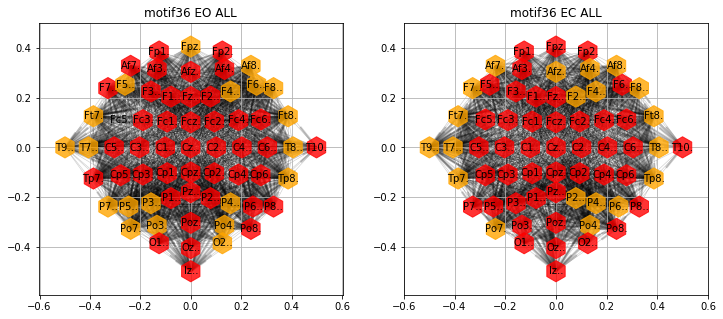

In [39]:
plot_motif36()

### Orange nodes represent high in-degree nodes

## 3.3 (C) ------------------------------------------------------------------------
#### Choose a channel selected in parieto-occipital scalp region and determine the motifs which involve it.

In [40]:
Po_dict = {key:value for key, value in label_dict.items() if "Po" in value}
Po_ID = list(Po_dict.keys())
Not_Po_ID = [i for i in range(0,64) if i not in Po_ID]

# Eyes Open ---------------------------------------------
matrix  = pdc_binary_matrix["EO"][20]
for i in Not_Po_ID:
    for j in Not_Po_ID:
        matrix[i][j] = 0

df = create_df_bridges(matrix)
df.to_csv("../input/motif/pdc_20_open_PO.txt", sep = "\t", index=False, header=False)

# Eyes Closed ---------------------------------------------
matrix  = pdc_binary_matrix["EC"][20]
for i in Not_Po_ID:
    for j in Not_Po_ID:
        matrix[i][j] = 0
        
df = create_df_bridges(matrix)
df.to_csv("../input/motif/pdc_20_closed_PO.txt", sep = "\t", index=False, header=False)

### Motif Analysis for Eyes Open

In [41]:
motif3_open_PO = motif_analysis("../input/motif/motif3_pdc_20_EO_PO_MAT.txt")
motif3_open_PO

not significant    10
motif               2
anti-motif          1
Name: Statistical_Significance, dtype: int64


Motif_ID  Frequency Statistical_Significance
0        6.0       54.0                    motif
1       12.0      232.0                    motif
2       14.0       67.0          not significant
3       36.0      408.0          not significant
4       38.0       16.0          not significant
5       46.0       10.0          not significant
6       74.0      234.0          not significant
7       78.0       19.0          not significant
8       98.0        0.0          not significant
9      102.0        4.0               anti-motif
10     108.0       25.0          not significant
11     110.0       16.0          not significant
12     238.0        4.0          not significant

### Motif Analysis for Eyes Closed

In [42]:
motif3_closed_PO = motif_analysis("../input/motif/motif3_pdc_20_EC_PO_MAT.txt")
motif3_closed_PO

not significant    10
motif               2
anti-motif          1
Name: Statistical_Significance, dtype: int64


Motif_ID  Frequency Statistical_Significance
0        6.0       41.0                    motif
1       12.0      253.0                    motif
2       14.0       68.0          not significant
3       36.0      562.0          not significant
4       38.0       17.0               anti-motif
5       46.0        9.0          not significant
6       74.0      322.0          not significant
7       78.0       36.0          not significant
8       98.0        0.0          not significant
9      102.0        3.0          not significant
10     108.0       24.0          not significant
11     110.0       12.0          not significant
12     238.0        4.0          not significant

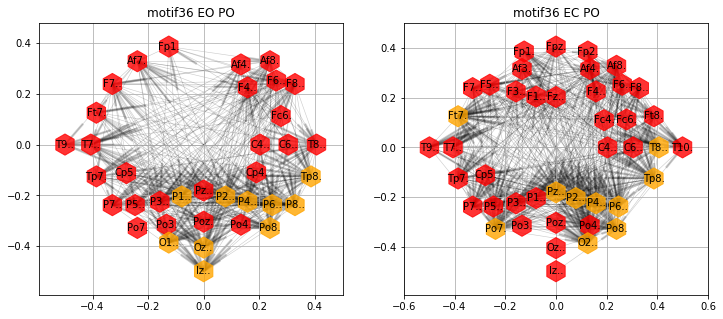

In [43]:
plot_motif36(PO=True)

## 3.4 (E) ---------------------------------------------------------------------------
#### Perform the same analysis described in task 3.1 considering 4-node motifs.

### Motif Analysis for Eyes Open

In [44]:
motif4_open = motif_analysis("../input/motif/motif4_pdc_20_EO_MAT.txt")
motif4_open.sort_values(by=["Frequency"], ascending = False).head(10)

anti-motif         90
not significant    56
motif              53
Name: Statistical_Significance, dtype: int64


Motif_ID  Frequency Statistical_Significance
4       76.0    23213.0               anti-motif
24     392.0    12807.0                    motif
59    2186.0    11220.0          not significant
58    2184.0     8476.0               anti-motif
3       74.0     7929.0          not significant
5       78.0     7064.0          not significant
30     408.0     6004.0          not significant
85    4436.0     5600.0               anti-motif
28     404.0     4404.0               anti-motif
12     280.0     4264.0               anti-motif

### Motif Analysis for Eyes Closed

In [45]:
motif4_closed = motif_analysis("../input/motif/motif4_pdc_20_EC_MAT.txt")
motif4_closed.sort_values(by=["Frequency"], ascending = False).head(10)

anti-motif         93
not significant    59
motif              47
Name: Statistical_Significance, dtype: int64


Motif_ID  Frequency Statistical_Significance
4       76.0    20395.0               anti-motif
24     392.0    12571.0                    motif
3       74.0     9102.0          not significant
59    2186.0     9091.0          not significant
5       78.0     6514.0               anti-motif
58    2184.0     6349.0               anti-motif
30     408.0     5455.0          not significant
12     280.0     4849.0          not significant
28     404.0     4713.0               anti-motif
85    4436.0     4616.0          not significant

# 4. Community detection <a name="4"></a>

## 4.1 (mandatory) ----------------------------------------------------------------
#### Determine number and composition (i.e. list of nodes) of the communities obtained applying one of the algorithms introduced during the course.

## 4.2 (B) --------------------------------------------------------------------------
#### Make a graphical representation of the community structure in both rest conditions.

In [46]:
# Divide nodes into partitions (communities)
def community_detection(matrix):
    G = nx.from_numpy_matrix(matrix) # use only UN-Directed graph
    
    # In this library, the partitions are obtained by Louvain Algorithm
    # https://github.com/taynaud/python-louvain
    best_partitions = community.best_partition(G, random_state=1111)

    # List up labels for each community
    nodes_community = defaultdict(list)
    for key, value in best_partitions.items():
        nodes_community[value].append(label_dict[key])
    print("Number of communities:", len(nodes_community))
    
    for i in range(len(nodes_community)):
        print("Community ", i)
        print("Number of Nodes", len(nodes_community[i]))
        print("\t", nodes_community[i])
    
    return G, nodes_community

In [47]:
def plot_community(estimator):
    
    fig, ax = plt.subplots(1, 2, figsize=((12, 5)))
    
    if estimator == "PDC":
        matrixes = pdc_binary_matrix
    else: 
        matrixes = dtf_binary_matrix
        
    for idx, eyes in enumerate(["EO", "EC"]):
        print("\n", eyes, " ---------------------------------------------------------------------------------------------------------------------------------- \n")
        matrix = matrixes[eyes][30]
        name = "Community " + str(estimator) + " " + str(eyes) + " 30% density"
        
        G, community = community_detection(matrix)

        colors = ["r", "b", "g", "orange", "pink"]
        label_map = {v: k for k, v in label_dict.items()}
        color_map = np.zeros(len(label_map))

        for i in range(len(community)):
            nodes = [label_map[node] for node in sorted(community[i])]
            color_map[nodes] = i

        color_map = [colors[int(i)] for i in color_map]
        nx.draw_networkx_nodes(G, positions, node_color = color_map, node_shape="h", node_size=500, alpha=0.6, ax = ax[idx])
        nx.draw_networkx_labels(G, positions, label_dict, font_size=10, alpha=0.1, ax = ax[idx])

        ax[idx].grid()
        ax[idx].set_title(name)
    
    plt.savefig("../output/4.2_" + estimator + ".png")
    plt.show()


 EO  ---------------------------------------------------------------------------------------------------------------------------------- 

Number of communities: 4
Community  0
Number of Nodes 14
	 ['Fc5.', 'C5..', 'C3..', 'Cp5.', 'F5..', 'F3..', 'F1..', 'F4..', 'Ft7.', 'T7..', 'T9..', 'Tp7.', 'P3..', 'P1..']
Community  1
Number of Nodes 22
	 ['Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'C1..', 'C2..', 'C4..', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Afz.', 'Af4.', 'Af8.', 'Fz..', 'F2..', 'F6..', 'F8..', 'Pz..', 'P4..']
Community  2
Number of Nodes 10
	 ['Fc6.', 'Cz..', 'C6..', 'Cp1.', 'Cpz.', 'Cp2.', 'Cp6.', 'Ft8.', 'T8..', 'T10.']
Community  3
Number of Nodes 18
	 ['Cp3.', 'Cp4.', 'F7..', 'Tp8.', 'P7..', 'P5..', 'P2..', 'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..', 'O2..', 'Iz..']

 EC  ---------------------------------------------------------------------------------------------------------------------------------- 

Number of communities: 3
Community  0
Number 

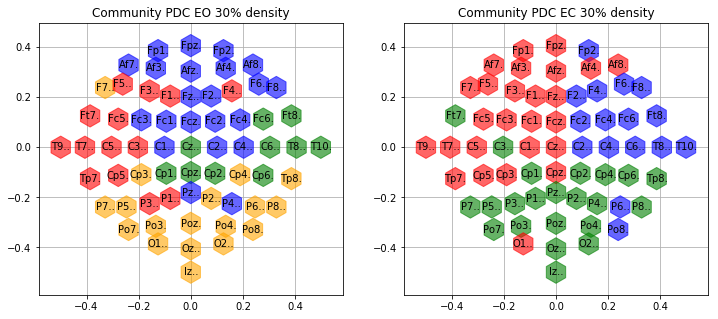


 EO  ---------------------------------------------------------------------------------------------------------------------------------- 

Number of communities: 4
Community  0
Number of Nodes 10
	 ['Fc5.', 'Fcz.', 'Fc4.', 'Fc6.', 'Cz..', 'Cpz.', 'Afz.', 'F2..', 'F4..', 'T9..']
Community  1
Number of Nodes 18
	 ['Fc3.', 'Fc1.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.', 'Af4.', 'Af8.', 'F7..', 'F3..', 'F6..', 'F8..', 'Ft8.', 'Pz..', 'O1..', 'O2..', 'Iz..']
Community  2
Number of Nodes 18
	 ['Fc2.', 'C1..', 'C2..', 'C4..', 'C6..', 'Cp2.', 'F1..', 'Fz..', 'Tp8.', 'P1..', 'P2..', 'P4..', 'P8..', 'Po7.', 'Poz.', 'Po4.', 'Po8.', 'Oz..']
Community  3
Number of Nodes 18
	 ['C5..', 'C3..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cp4.', 'Cp6.', 'F5..', 'Ft7.', 'T7..', 'T8..', 'T10.', 'Tp7.', 'P7..', 'P5..', 'P3..', 'P6..', 'Po3.']

 EC  ---------------------------------------------------------------------------------------------------------------------------------- 

Number of communities: 3
Community  0
Number 

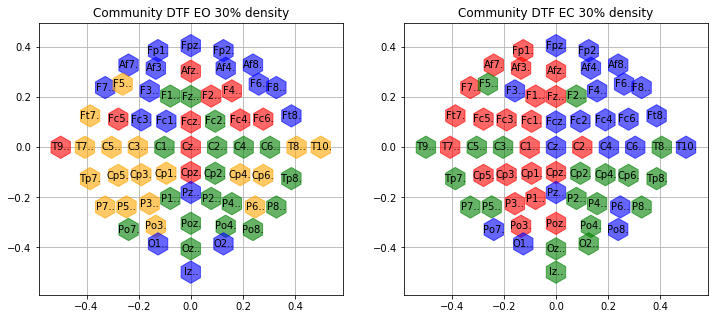

In [48]:
plot_community("PDC")
plot_community("DTF")